### Part 2
Create one or more reasonable baselines for Fake News predictor. Aim to train a binary classification model that can predict whether an article is reliable or fake

### Task #0
- Discuss how you grouped the labels into two groups. 
- Are there any limitations that could arise from the decision we've made when grouping the labels

1. We've grouped the labels into two groups, 'content' and 'type', to optimize our fake news predictor in defining whether the article is reliable or unreliable. 
2. The decision to group labels into two groups can have limitations, primarily if the labels have overlapping information. This doesn't seem to be the case in our situation, 
3. So we tried to label it as reliable and fake, but we came across the problem that we had stemmed 'reliable' so it could not label all the articles, so we made a if statement instead

### Task #1
- Start by considering only features extracted from 'content' column. 
- Choose one or more simple baseline models, train them, and report accuracies. 
- Report necessary details about baseline models (choice of relevant parameters and how you chose them). 
- Describe why you chose these baseline models - why are they reasonable?

In [1]:
# Import the necessary libraries
# pip install dask-ml
import dask.dataframe as dd
import dask_ml.model_selection
import numpy as np

In [2]:
# Read the CSV file into a Dask DataFrame with specified data types
# These dtypes can be found by printing the dask dataframe
cleaned_data = dd.read_csv('data_3GB.csv', encoding="utf-8", dtype={
        'Unnamed: 0': 'object',
        'id': 'object',
        'domain': 'object',
        'type': 'object',
        'url': 'object',
        'content': 'object',
        'scraped_at': 'object',
        'inserted_at': 'object',
        'updated_at': 'object',
        'title': 'object',
        'authors': 'object',
        'keywords': 'float64',
        'meta_keywords': 'object',
        'meta_description': 'object',
        'tags': 'object',
        'summary': 'float64',
        'tokens': 'object',
        'filtered_tokens': 'object',
        'stemmed_tokens': 'object',
    },)

In [3]:
# Define a function to modify the 'type' column values
# This function is used to simplify the classification problem
# The 'reliable' and 'political' types are combined into a single 'reliable' type
def modify_type(x):
    if x == 'reliabl' or x == 'polit':
        return 'reliable'
    else:
        return 'fake'

In [4]:
# Apply the modify_type function to the 'type' column using the map function
cleaned_data['type'] = cleaned_data['type'].map(modify_type, meta=('type', 'object'))

In [5]:
# Identify if there are any missing values in the 'type' column
# If so, they are replaced with an empty string
def nan_to_empty(x):
    if isinstance(x, float) and np.isnan(x):
        return ''
    else:
        return x

In [6]:
# Apply the nan_to_empty function to the 'type' column using the map function
cleaned_data['content'] = cleaned_data['content'].map(nan_to_empty, meta=('content', 'object'))

In [7]:
# Define X and y as the 'content' and 'type' columns
y = cleaned_data['type']
X = cleaned_data['content']

In [8]:
# Split the data into train and test sets
# In an 80/10/10 split

X_train, X_test, y_train, y_test = dask_ml.model_selection.train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
X_train, X_val, y_train, y_val = dask_ml.model_selection.train_test_split(X_train, y_train, test_size=0.5, random_state=0, shuffle=False)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object for use in feature extraction
vectorization = TfidfVectorizer()

# Fit the vectorizer to the training data and transform the training data into a vector
# As well as the validation data
xv_train = vectorization.fit_transform(X_train)
xv_val = vectorization.transform(X_val) 

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define a range of C values to test
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Initialize the best_C and best_score variables
best_C = None
best_score = 0

# Iterate through the C_values and fit the model with each value
for C in C_values:
    # Create a Logistic Regression model with the current C value
    model = LogisticRegression(max_iter=1500, class_weight = 'balanced', random_state = 0, C=C)
    
    # Fit the model to the training data
    model.fit(xv_train, y_train)
    
    # Predict the validation data
    y_val_pred = model.predict(xv_val)
    
    # Calculate the accuracy score for the current C value
    score = accuracy_score(y_val, y_val_pred)
    
    # Print the current C value and its accuracy score
    print(f"C: {C}, Accuracy: {score}")
    
    # Update the best_C and best_score variables if the current score is higher than the previous best
    if score > best_score:
        best_C = C
        best_score = score

# Print the best C value and its accuracy score
print(f"Best C: {best_C}, Best Accuracy: {best_score}")

C: 0.001, Accuracy: 0.7954201575477414
C: 0.01, Accuracy: 0.830345901109946
C: 0.1, Accuracy: 0.8561315534526613
C: 1, Accuracy: 0.8767992626968893
C: 10, Accuracy: 0.8902971346049877


/Users/Agnes/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C: 100, Accuracy: 0.893045693199177


/Users/Agnes/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C: 1000, Accuracy: 0.8874977775681334
Best C: 100, Best Accuracy: 0.893045693199177


In [11]:
# Print the accuracy of the model on the validation data
model.score(xv_val,y_val)

0.8874977775681334

In [12]:
# Predict the class of the validation data
pred_model = model.predict(xv_val)

In [13]:
from sklearn.metrics import classification_report

# Print the classification report for the model
print(classification_report(y_val,pred_model))

              precision    recall  f1-score   support

        fake       0.94      0.91      0.93    427966
    reliable       0.72      0.81      0.76    123232

    accuracy                           0.89    551198
   macro avg       0.83      0.86      0.84    551198
weighted avg       0.89      0.89      0.89    551198



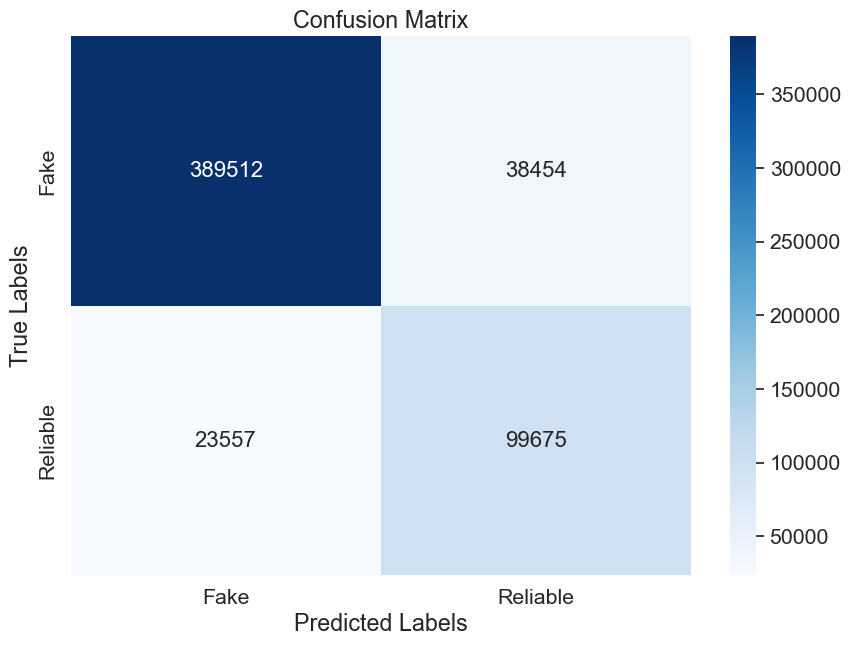

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_val, pred_model)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt="d", cmap="Blues", xticklabels=['Fake', 'Reliable'], yticklabels=['Fake', 'Reliable'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Task #2
- Consider whether it would make sense to include meta-data features as well. If so, which ones, and why? 
- If relevant, report performance when including these additional features and compare it to the first baselines. 
- Discuss whether these results match expectations

For the remainder of the project, we will limit ourselves to main-text data only (i.e. no meta-data). This makes it easier to do the cross-domain experiment in Part 4 (which does not have the same set of meta-data fields).